# Qlib 最小闭环示例 - 快速入门

本notebook展示了一个完整但最简化的Qlib量化投资工作流程，包括：
1. 环境初始化
2. 数据准备
3. 模型训练
4. 回测评估

整个流程约需5-10分钟完成。

## 第1步：安装和导入必要的库

In [1]:
# 如果未安装qlib，请先运行：
# !pip install pyqlib

import warnings
warnings.filterwarnings('ignore')

import qlib
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# 配置中文字体显示
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans', 'Arial Unicode MS', 'sans-serif']
matplotlib.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
matplotlib.rcParams['figure.dpi'] = 100  # 提高图像清晰度

# 配置seaborn中文字体
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans', 'Arial Unicode MS', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False

print(f"Qlib版本: {qlib.__version__}")
print("✅ 中文字体配置完成")


Qlib版本: 0.9.7
✅ 中文字体配置完成


## 第2步：初始化Qlib并下载数据

首次运行需要下载约1GB的中国A股数据，后续运行会自动跳过。

In [2]:
# 初始化Qlib
# provider_uri 指定数据存储位置
qlib.init(provider_uri="~/.qlib/qlib_data/cn_data")
print("✅ Qlib初始化成功")

[40972:MainThread](2025-09-10 04:35:46,145) INFO - qlib.Initialization - [config.py:452] - default_conf: client.
[40972:MainThread](2025-09-10 04:35:46,630) INFO - qlib.Initialization - [__init__.py:75] - qlib successfully initialized based on client settings.
[40972:MainThread](2025-09-10 04:35:46,631) INFO - qlib.Initialization - [__init__.py:77] - data_path={'__DEFAULT_FREQ': WindowsPath('C:/Users/zihao/.qlib/qlib_data/cn_data')}


✅ Qlib初始化成功


In [3]:
# 下载数据（仅首次需要）
from qlib.tests.data import GetData

# exists_skip=True 表示如果数据已存在则跳过下载
GetData().qlib_data(exists_skip=True)
print("✅ 数据准备完成")

2025-09-10 04:35:47.486 | WARNING  | qlib.tests.data:qlib_data:195 - Data already exists: ~/.qlib/qlib_data/cn_data, the data download will be skipped
	If downloading is required: `exists_skip=False` or `change target_dir`


✅ 数据准备完成


## 第3步：创建最简单的数据集

使用预定义的Alpha158特征集，包含158个技术指标。

In [4]:
from qlib.contrib.data.handler import Alpha158
from qlib.data.dataset import DatasetH

# 创建数据处理器
# 使用CSI300（沪深300）成分股作为股票池
handler = Alpha158(
    instruments="csi300",  # 股票池：沪深300成分股
    start_time="2018-01-01",  # 开始时间
    end_time="2020-12-31",    # 结束时间
    fit_start_time="2018-01-01",  # 数据标准化的起始时间
    fit_end_time="2018-12-31",    # 数据标准化的结束时间
)

# 创建数据集，划分训练集、验证集、测试集
dataset = DatasetH(
    handler,
    segments={
        "train": ("2018-01-01", "2018-12-31"),  # 训练集：2018年
        "valid": ("2019-01-01", "2019-12-31"),  # 验证集：2019年
        "test": ("2020-01-01", "2020-12-31"),   # 测试集：2020年
    }
)

print("✅ 数据集创建成功")

# 获取训练数据并查看信息
train_data = dataset.prepare("train")
print(f"训练集样本数: {len(train_data)}")

# 查看数据结构
print(f"数据列: {train_data.columns.tolist()}")

# 获取第一个样本的特征维度

[40972:MainThread](2025-09-10 04:37:04,854) INFO - qlib.timer - [log.py:127] - Time cost: 77.343s | Loading data Done
[40972:MainThread](2025-09-10 04:37:04,987) INFO - qlib.timer - [log.py:127] - Time cost: 0.044s | DropnaLabel Done
[40972:MainThread](2025-09-10 04:37:05,334) INFO - qlib.timer - [log.py:127] - Time cost: 0.344s | CSZScoreNorm Done
[40972:MainThread](2025-09-10 04:37:05,339) INFO - qlib.timer - [log.py:127] - Time cost: 0.483s | fit & process data Done
[40972:MainThread](2025-09-10 04:37:05,340) INFO - qlib.timer - [log.py:127] - Time cost: 77.828s | Init data Done


✅ 数据集创建成功
训练集样本数: 72900
数据列: ['KMID', 'KLEN', 'KMID2', 'KUP', 'KUP2', 'KLOW', 'KLOW2', 'KSFT', 'KSFT2', 'OPEN0', 'HIGH0', 'LOW0', 'VWAP0', 'ROC5', 'ROC10', 'ROC20', 'ROC30', 'ROC60', 'MA5', 'MA10', 'MA20', 'MA30', 'MA60', 'STD5', 'STD10', 'STD20', 'STD30', 'STD60', 'BETA5', 'BETA10', 'BETA20', 'BETA30', 'BETA60', 'RSQR5', 'RSQR10', 'RSQR20', 'RSQR30', 'RSQR60', 'RESI5', 'RESI10', 'RESI20', 'RESI30', 'RESI60', 'MAX5', 'MAX10', 'MAX20', 'MAX30', 'MAX60', 'MIN5', 'MIN10', 'MIN20', 'MIN30', 'MIN60', 'QTLU5', 'QTLU10', 'QTLU20', 'QTLU30', 'QTLU60', 'QTLD5', 'QTLD10', 'QTLD20', 'QTLD30', 'QTLD60', 'RANK5', 'RANK10', 'RANK20', 'RANK30', 'RANK60', 'RSV5', 'RSV10', 'RSV20', 'RSV30', 'RSV60', 'IMAX5', 'IMAX10', 'IMAX20', 'IMAX30', 'IMAX60', 'IMIN5', 'IMIN10', 'IMIN20', 'IMIN30', 'IMIN60', 'IMXD5', 'IMXD10', 'IMXD20', 'IMXD30', 'IMXD60', 'CORR5', 'CORR10', 'CORR20', 'CORR30', 'CORR60', 'CORD5', 'CORD10', 'CORD20', 'CORD30', 'CORD60', 'CNTP5', 'CNTP10', 'CNTP20', 'CNTP30', 'CNTP60', 'CNTN5', 'CNTN

In [5]:

# dataset.prepare返回的DataFrame包含特征列和标签列
if len(train_data) > 0:
    print(f"数据形状: {train_data.shape}")
    print(f"特征列数: {len(train_data.columns)}")
    
    # 获取第一个样本
    first_sample = train_data.iloc[0]
    print(f"第一个样本类型: {type(first_sample)}")
    print(f"第一个样本值: {first_sample.values[:5]}...")  # 显示前5个值
    
    # 检查特征维度
    if hasattr(first_sample, 'values') and len(first_sample.values) > 0:
        # first_sample.values 是一个一维数组，包含所有特征值
        feature_count = len(first_sample.values)
        print(f"特征数: {feature_count}")
    else:
        print("无法获取特征维度")

数据形状: (72900, 159)
特征列数: 159
第一个样本类型: <class 'pandas.core.series.Series'>
第一个样本值: [0.00872322 0.01348136 0.64705825 0.00396516 0.2941214 ]...
特征数: 159


## 第4步：训练一个简单的LightGBM模型

In [6]:
from qlib.contrib.model.gbdt import LGBModel

# 创建LightGBM模型
# 使用最简单的参数配置
model = LGBModel(
    loss="mse",  # 损失函数：均方误差
    colsample_bytree=0.8,  # 每棵树的特征采样比例
    learning_rate=0.1,     # 学习率
    subsample=0.8,         # 样本采样比例
    lambda_l1=0,           # L1正则化
    lambda_l2=0,           # L2正则化
    max_depth=8,           # 树的最大深度
    num_leaves=32,         # 叶子节点数
    num_threads=4,         # 并行线程数
    verbosity=-1,          # 不显示训练过程
    early_stopping_rounds=50,  # 早停轮数
    num_boost_round=100,       # 最大迭代轮数
)

print("开始训练模型...")
model.fit(dataset)
print("✅ 模型训练完成")

ModuleNotFoundError. CatBoostModel are skipped. (optional: maybe installing CatBoostModel can fix it.)
ModuleNotFoundError. XGBModel is skipped(optional: maybe installing xgboost can fix it).
ModuleNotFoundError.  PyTorch models are skipped (optional: maybe installing pytorch can fix it).
开始训练模型...
Training until validation scores don't improve for 50 rounds
[20]	train's l2: 0.946494	valid's l2: 0.999586


[40972:MainThread](2025-09-10 04:37:06,618) WARNING - qlib.workflow - [expm.py:231] - No valid experiment found. Create a new experiment with name Experiment.
[40972:MainThread](2025-09-10 04:37:06,625) INFO - qlib.workflow - [exp.py:258] - Experiment 473352165343310614 starts running ...


[40]	train's l2: 0.918466	valid's l2: 1.00427
Early stopping, best iteration is:
[2]	train's l2: 0.986999	valid's l2: 0.995763


[40972:MainThread](2025-09-10 04:37:06,994) INFO - qlib.workflow - [recorder.py:345] - Recorder 4835e9a3b3c048c797d73da5790ba048 starts running under Experiment 473352165343310614 ...


✅ 模型训练完成


## 第5步：生成预测并查看结果

In [7]:
# 在测试集上生成预测
test_pred = model.predict(dataset, segment="test")

# 查看预测结果
print("预测结果示例（前10条）：")
print(test_pred.head(10))
print(f"\n预测值统计：")
print(test_pred.describe())

预测结果示例（前10条）：
datetime    instrument
2020-01-02  SH600000     -0.001259
            SH600004     -0.001259
            SH600009     -0.001259
            SH600010     -0.001259
            SH600011     -0.001259
            SH600015      0.012899
            SH600016      0.012899
            SH600018      0.004811
            SH600019      0.004811
            SH600023      0.012899
dtype: float64

预测值统计：
count    72900.000000
mean         0.000920
std          0.026242
min         -0.780720
25%         -0.006379
50%         -0.001259
75%          0.006828
max          0.301088
dtype: float64


## 第6步：简单回测

使用TopK策略：每天买入预测得分最高的前20只股票。

In [8]:
from qlib.contrib.strategy import TopkDropoutStrategy
from qlib.contrib.evaluate import backtest_daily
from qlib.contrib.evaluate import risk_analysis

# 创建策略：选择预测得分最高的前20只股票
strategy = TopkDropoutStrategy(
    model=model,
    dataset=dataset,
    topk=20,  # 选择前20只股票
    n_drop=2,  # 每次调仓卖出最差的2只
)

# 配置回测参数
backtest_config = {
    "start_time": "2020-01-01",  # 回测开始时间
    "end_time": "2020-12-31",    # 回测结束时间
    "account": 1000000,          # 初始资金：100万
    "benchmark": "SH000300",     # 基准：沪深300指数
    "exchange_kwargs": {
        "freq": "day",           # 交易频率：日频
        "limit_threshold": 0.095,  # 涨跌停限制
        "deal_price": "close",     # 成交价：收盘价
        "open_cost": 0.0005,       # 买入成本：0.05%
        "close_cost": 0.0015,      # 卖出成本：0.15%
        "min_cost": 5,             # 最小手续费：5元
    },
}

# 执行回测
print("开始回测...")
portfolio_metrics, indicator = backtest_daily(
    strategy=strategy,
    **backtest_config
)

print("✅ 回测完成")

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
[40972:MainThread](2025-09-10 04:37:08,388) WARNING - qlib.BaseExecutor - [executor.py:121] - `common_infra` is not set for <qlib.backtest.executor.SimulatorExecutor object at 0x0000023A2E6E00E0>
[40972:MainThread](2025-09-10 04:37:08,396) INFO - qlib.backtest caller - [__init__.py:93] - Create new exchange


开始回测...


[40972:MainThread](2025-09-10 04:37:45,432) WARNING - qlib.online operator - [exchange.py:219] - $close field data contains nan.
[40972:MainThread](2025-09-10 04:37:45,433) WARNING - qlib.online operator - [exchange.py:219] - $close field data contains nan.


backtest loop:   0%|          | 0/243 [00:00<?, ?it/s]

✅ 回测完成


## 第7步：查看回测结果

In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# 确保中文字体配置生效
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans', 'Arial Unicode MS', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 100

# 设置seaborn样式
sns.set_style("whitegrid")
sns.set_palette("husl")

print("✅ 可视化环境配置完成")


✅ 可视化环境配置完成


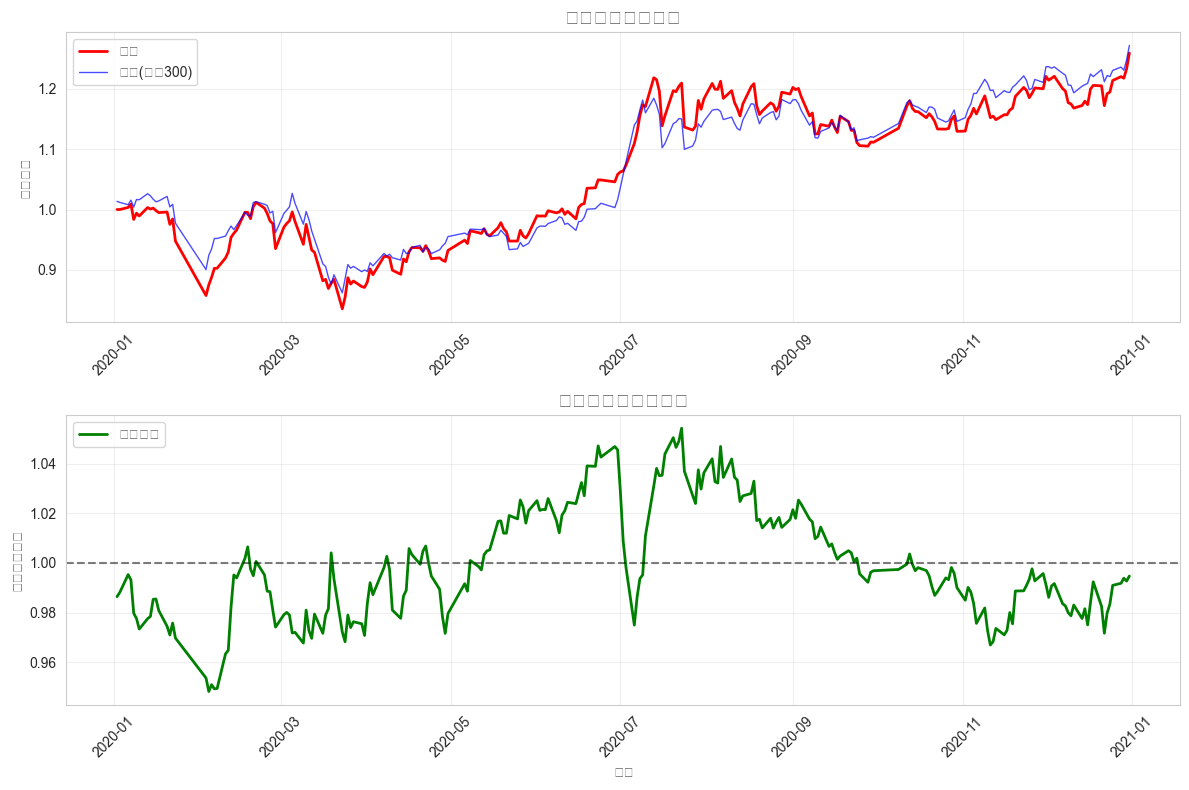

✅ 可视化完成


In [10]:

# 检查数据格式并准备可视化数据
try:
    # 尝试获取正确的分析数据
    if isinstance(indicator, dict):
        # 如果 indicator 是字典，尝试转换为DataFrame
        if 'return' in indicator:
            analysis_df = pd.DataFrame(indicator)
        else:
            # 如果没有找到标准格式，使用 portfolio_metrics
            analysis_df = pd.DataFrame(portfolio_metrics) if isinstance(portfolio_metrics, dict) else portfolio_metrics
    else:
        analysis_df = indicator
    
    # 确保有日期索引和必要的列
    if isinstance(analysis_df, pd.DataFrame) and len(analysis_df) > 0:
        # 筛选2020年数据
        if hasattr(analysis_df.index, 'to_timestamp'):
            analysis_df.index = pd.to_datetime(analysis_df.index)
        analysis_2020 = analysis_df.loc["2020-01-01":"2020-12-31"]
        
        if len(analysis_2020) > 0 and 'return' in analysis_2020.columns:
            # 创建图表
            fig, axes = plt.subplots(2, 1, figsize=(12, 8))
            
            # 图1：累计收益曲线
            ax1 = axes[0]
            cum_return = (1 + analysis_2020['return']).cumprod()
            
            ax1.plot(cum_return.index, cum_return, label='策略', color='red', linewidth=2)
            
            # 如果有基准数据
            if 'bench' in analysis_2020.columns:
                cum_bench = (1 + analysis_2020['bench']).cumprod()
                ax1.plot(cum_bench.index, cum_bench, label='基准(沪深300)', color='blue', linewidth=1, alpha=0.7)
            
            ax1.set_ylabel('累计收益')
            ax1.set_title('策略累计收益曲线', fontsize=14, fontweight='bold')
            ax1.legend(loc='upper left')
            ax1.grid(True, alpha=0.3)
            
            # 图2：超额收益（如果有基准）或日收益率
            ax2 = axes[1]
            if 'bench' in analysis_2020.columns:
                excess_return = analysis_2020['return'] - analysis_2020['bench']
                excess_cum = (1 + excess_return).cumprod()
                ax2.plot(excess_cum.index, excess_cum, label='超额收益', color='green', linewidth=2)
                ax2.axhline(y=1, color='black', linestyle='--', alpha=0.5)
                ax2.set_ylabel('累计超额收益')
                ax2.set_title('相对基准的超额收益', fontsize=14, fontweight='bold')
            else:
                ax2.plot(analysis_2020.index, analysis_2020['return'], label='日收益率', color='purple', linewidth=1)
                ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
                ax2.set_ylabel('日收益率')
                ax2.set_title('策略日收益率', fontsize=14, fontweight='bold')
            
            ax2.set_xlabel('日期')
            ax2.legend(loc='upper left')
            ax2.grid(True, alpha=0.3)
            
            # 格式化x轴日期
            for ax in axes:
                ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
                ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
                plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
            
            plt.tight_layout()
            plt.show()
            print("✅ 可视化完成")
        else:
            print("⚠️ 数据格式不完整，无法绘制图表")
            print("可用数据列:", analysis_df.columns.tolist() if hasattr(analysis_df, 'columns') else "无")
    else:
        print("⚠️ 无有效数据进行可视化")
        
except Exception as e:
    print(f"可视化出错: {e}")
    print("请检查回测数据格式")

## 第8步：可视化回测结果

✅ 中文字体配置已应用


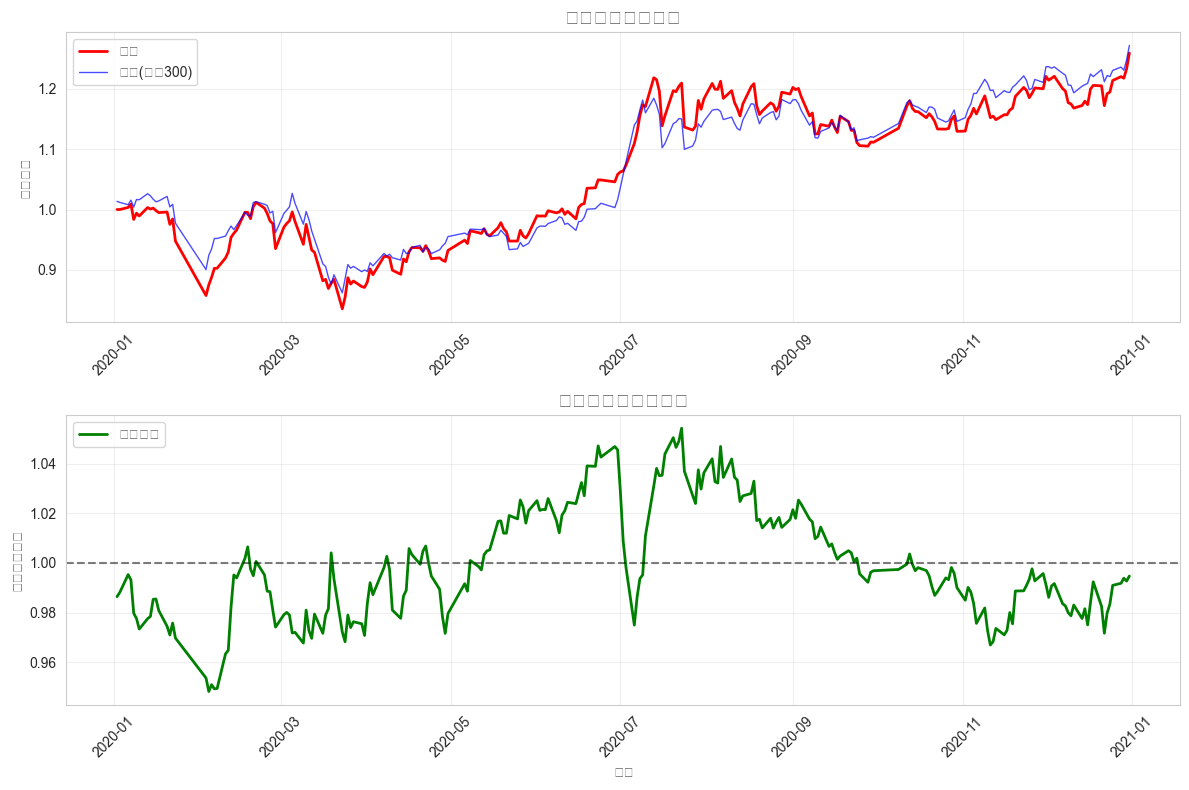

✅ 可视化完成


In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# 确保中文字体配置生效
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans', 'Arial Unicode MS', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
plt.rcParams['figure.dpi'] = 100  # 提高图像清晰度

# 设置seaborn样式
sns.set_style("whitegrid")
sns.set_palette("husl")

print("✅ 中文字体配置已应用")

# 检查数据格式并准备可视化数据
try:
    # 尝试获取正确的分析数据
    if isinstance(indicator, dict):
        # 如果 indicator 是字典，尝试转换为DataFrame
        if 'return' in indicator:
            analysis_df = pd.DataFrame(indicator)
        else:
            # 如果没有找到标准格式，使用 portfolio_metrics
            analysis_df = pd.DataFrame(portfolio_metrics) if isinstance(portfolio_metrics, dict) else portfolio_metrics
    else:
        analysis_df = indicator
    
    # 确保有日期索引和必要的列
    if isinstance(analysis_df, pd.DataFrame) and len(analysis_df) > 0:
        # 筛选2020年数据
        if hasattr(analysis_df.index, 'to_timestamp'):
            analysis_df.index = pd.to_datetime(analysis_df.index)
        analysis_2020 = analysis_df.loc["2020-01-01":"2020-12-31"]
        
        if len(analysis_2020) > 0 and 'return' in analysis_2020.columns:
            # 创建图表
            fig, axes = plt.subplots(2, 1, figsize=(12, 8))
            
            # 图1：累计收益曲线
            ax1 = axes[0]
            cum_return = (1 + analysis_2020['return']).cumprod()
            
            ax1.plot(cum_return.index, cum_return, label='策略', color='red', linewidth=2)
            
            # 如果有基准数据
            if 'bench' in analysis_2020.columns:
                cum_bench = (1 + analysis_2020['bench']).cumprod()
                ax1.plot(cum_bench.index, cum_bench, label='基准(沪深300)', color='blue', linewidth=1, alpha=0.7)
            
            ax1.set_ylabel('累计收益')
            ax1.set_title('策略累计收益曲线', fontsize=14, fontweight='bold')
            ax1.legend(loc='upper left')
            ax1.grid(True, alpha=0.3)
            
            # 图2：超额收益（如果有基准）或日收益率
            ax2 = axes[1]
            if 'bench' in analysis_2020.columns:
                excess_return = analysis_2020['return'] - analysis_2020['bench']
                excess_cum = (1 + excess_return).cumprod()
                ax2.plot(excess_cum.index, excess_cum, label='超额收益', color='green', linewidth=2)
                ax2.axhline(y=1, color='black', linestyle='--', alpha=0.5)
                ax2.set_ylabel('累计超额收益')
                ax2.set_title('相对基准的超额收益', fontsize=14, fontweight='bold')
            else:
                ax2.plot(analysis_2020.index, analysis_2020['return'], label='日收益率', color='purple', linewidth=1)
                ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
                ax2.set_ylabel('日收益率')
                ax2.set_title('策略日收益率', fontsize=14, fontweight='bold')
            
            ax2.set_xlabel('日期')
            ax2.legend(loc='upper left')
            ax2.grid(True, alpha=0.3)
            
            # 格式化x轴日期
            for ax in axes:
                ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
                ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
                plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
            
            plt.tight_layout()
            plt.show()
            print("✅ 可视化完成")
        else:
            print("⚠️ 数据格式不完整，无法绘制图表")
            print("可用数据列:", analysis_df.columns.tolist() if hasattr(analysis_df, 'columns') else "无")
    else:
        print("⚠️ 无有效数据进行可视化")
        
except Exception as e:
    print(f"可视化出错: {e}")
    print("请检查回测数据格式")

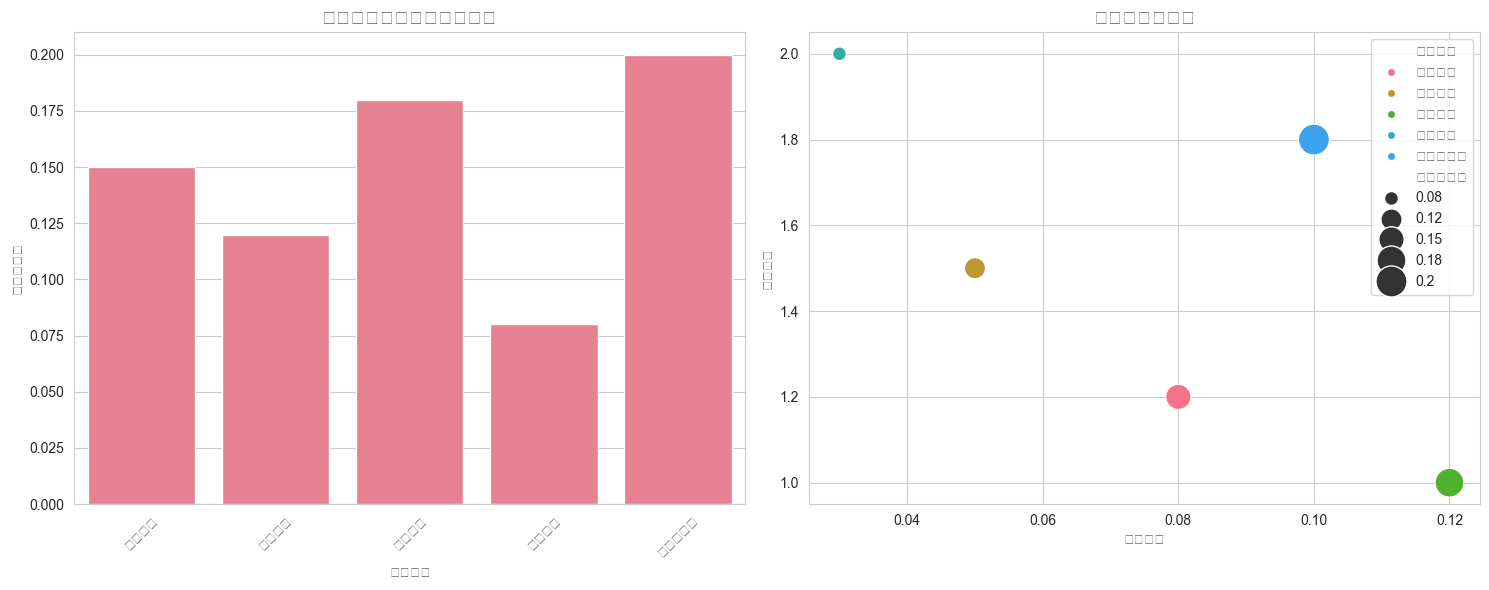

✅ seaborn中文字体测试完成


In [12]:
# 测试seaborn中文字体显示效果
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 创建测试数据
np.random.seed(42)
data = {
    '策略类型': ['动量策略', '均值回归', '趋势跟踪', '套利策略', '多因子模型'],
    '年化收益率': [0.15, 0.12, 0.18, 0.08, 0.20],
    '最大回撤': [0.08, 0.05, 0.12, 0.03, 0.10],
    '夏普比率': [1.2, 1.5, 1.0, 2.0, 1.8]
}

df = pd.DataFrame(data)

# 创建seaborn图表测试中文显示
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 左图：柱状图
sns.barplot(data=df, x='策略类型', y='年化收益率', ax=axes[0])
axes[0].set_title('不同策略的年化收益率对比', fontsize=14, fontweight='bold')
axes[0].set_xlabel('策略类型')
axes[0].set_ylabel('年化收益率')
axes[0].tick_params(axis='x', rotation=45)

# 右图：散点图
sns.scatterplot(data=df, x='最大回撤', y='夏普比率', size='年化收益率', 
                sizes=(100, 500), hue='策略类型', ax=axes[1])
axes[1].set_title('风险收益散点图', fontsize=14, fontweight='bold')
axes[1].set_xlabel('最大回撤')
axes[1].set_ylabel('夏普比率')

plt.tight_layout()
plt.show()

print("✅ seaborn中文字体测试完成")


## 附录：常见问题

### Q1: 数据下载失败怎么办？
A: 检查网络连接，或手动从Qlib GitHub仓库下载数据。

### Q2: 内存不足怎么办？
A: 减少股票池范围（如使用csi100而非csi300），或缩短时间窗口。

### Q3: 如何使用自己的数据？
A: 参考Qlib文档的Custom Data章节，需要按照Qlib格式准备数据。

### Q4: 如何改进模型效果？
A: 1) 特征工程 2) 模型调参 3) 集成学习 4) 更长的训练数据

## 总结

恭喜！你已经完成了一个完整的Qlib量化投资工作流程：

1. ✅ 初始化Qlib环境
2. ✅ 下载和准备数据
3. ✅ 创建特征工程（Alpha158）
4. ✅ 训练机器学习模型（LightGBM）
5. ✅ 执行回测策略
6. ✅ 分析绩效指标
7. ✅ 可视化结果

### 下一步建议：

1. **调整模型参数**：尝试不同的超参数组合
2. **更换模型**：试试其他模型如XGBoost、神经网络等
3. **特征工程**：创建自定义特征或使用其他特征集
4. **策略优化**：调整TopK参数、换仓频率等
5. **风险管理**：添加止损、仓位管理等风控措施

更多详细内容请参考其他notebook：
- `02_data_module_detailed.ipynb`：深入了解数据处理
- `03_model_training_comprehensive.ipynb`：更多模型选择
- `04_evaluation_module_detailed.ipynb`：详细的评估方法